In [63]:
#beginning code from https://www.kaggle.com/shanan93/brain-mri-segmentation-95-5-accuracy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import zipfile
import cv2
from skimage import io
from natsort import natsorted

import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

import os
import glob
import random
#%matplotlib inline

In [64]:
main_df = pd.read_csv('archive/lgg-mri-segmentation/kaggle_3m/data.csv')

In [65]:
data_map = []
for sub_dir_path in glob.glob("archive/lgg-mri-segmentation/kaggle_3m/"+"*"):
    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + '/' + filename
            data_map.extend([dir_name, image_path])
    except Exception as e:
        print(e)


[Errno 20] Not a directory: 'archive/lgg-mri-segmentation/kaggle_3m/data.csv'
[Errno 20] Not a directory: 'archive/lgg-mri-segmentation/kaggle_3m/README.md'


In [66]:
df = pd.DataFrame({"path" : data_map[1::2]})
df.head()

,path
0,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...
1,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...
2,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...
3,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...
4,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...


In [87]:
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

# File path line length images for later sorting
BASE_LEN = 89 
END_IMG_LEN = 4 
END_MASK_LEN = 9 

# Data sorting
imgs = natsorted(df_imgs["path"].values)
masks = natsorted(df_masks["path"].values)

imgs

['archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif',
 'archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_2.tif',
 'archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_3.tif',
 'archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_4.tif',
 'archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_5.tif',
 'archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_6.tif',
 'archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_7.tif',
 'archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_8.tif',
 'archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_9.tif',
 'archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10.tif',
 'archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_C

In [68]:
# Final dataframe
brain_df = pd.DataFrame({"image_path": imgs,
                         "mask_path": masks
                        })
def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : 
        return 1
    else:
        return 0
    
brain_df['label'] = brain_df['mask_path'].apply(lambda x: pos_neg_diagnosis(x))
brain_df

,image_path,mask_path,label
0,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...,0
1,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...,0
2,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...,0
3,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...,0
4,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...,0
...,...,...,...
3924,archive/lgg-mri-segmentation/kaggle_3m/TCGA_HT...,archive/lgg-mri-segmentation/kaggle_3m/TCGA_HT...,0
3925,archive/lgg-mri-segmentation/kaggle_3m/TCGA_HT...,archive/lgg-mri-segmentation/kaggle_3m/TCGA_HT...,0
3926,archive/lgg-mri-segmentation/kaggle_3m/TCGA_HT...,archive/lgg-mri-segmentation/kaggle_3m/TCGA_HT...,0
3927,archive/lgg-mri-segmentation/kaggle_3m/TCGA_HT...,archive/lgg-mri-segmentation/kaggle_3m/TCGA_HT...,0


In [69]:
brain_df['label'].value_counts()

0    2556
1    1373
Name: label, dtype: int64

IndexError: index 12 is out of bounds for axis 0 with size 12

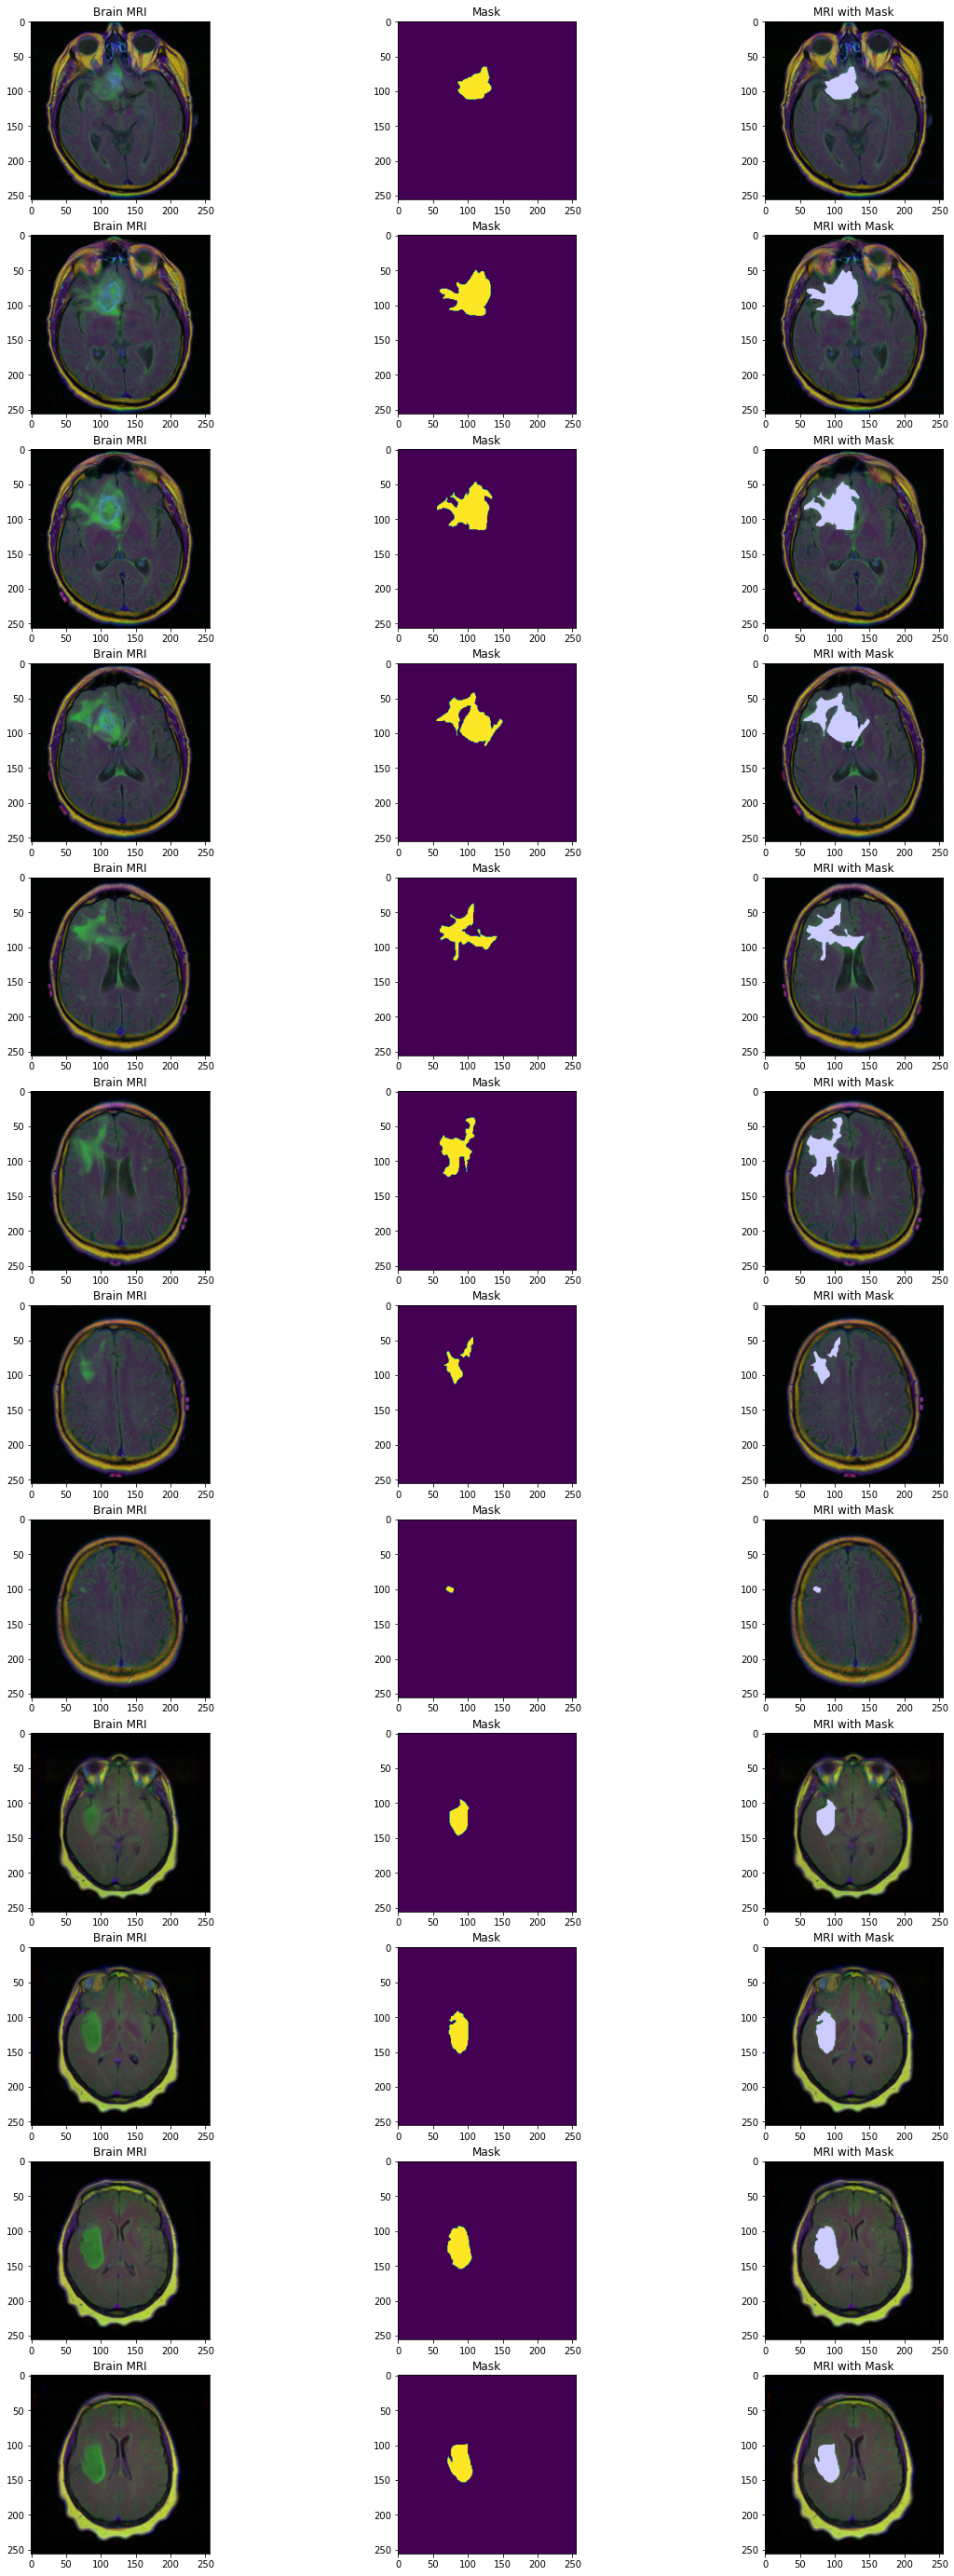

In [121]:
count = 0
fig, axs = plt.subplots(12, 3, figsize = (20,50))
for i in range(len(brain_df)):
    if brain_df['label'][i] ==1:
        img = io.imread(brain_df.image_path[i])
        axs[count][0].title.set_text('Brain MRI')
        axs[count][0].imshow(img)

        mask = io.imread(brain_df.mask_path[i])
        axs[count][1].title.set_text('Mask')
        axs[count][1].imshow(mask)


        img[mask==255] = (204, 204, 255)
        axs[count][2].title.set_text('MRI with Mask')
        axs[count][2].imshow(img)
        
        count+=1
fig.savefig('Brain_mri.png')
fig.tight_layout()


IndexError: index 12 is out of bounds for axis 0 with size 12

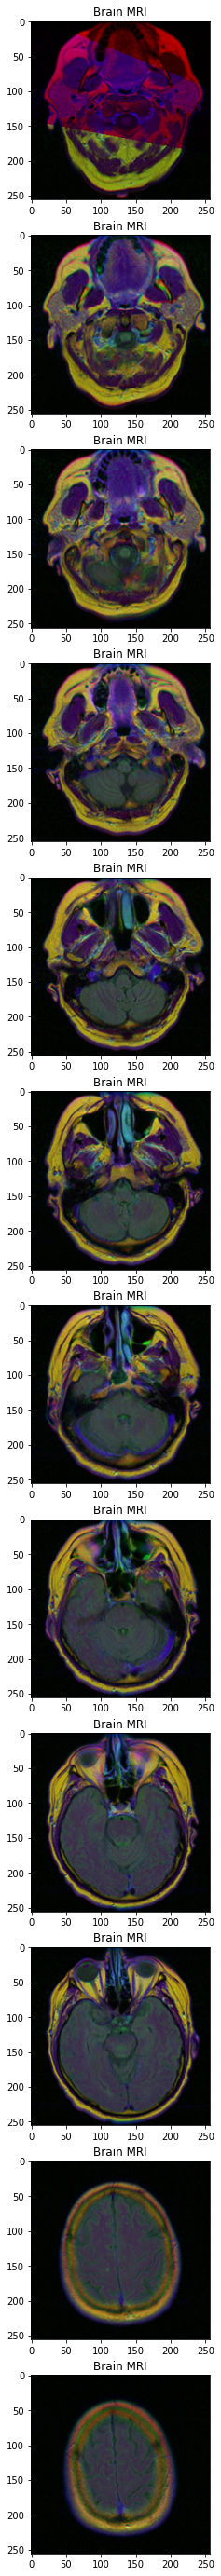

In [120]:
count = 0
fig, axs = plt.subplots(12, figsize = (20,50))
for i in range(len(brain_df)):
    if brain_df['label'][i] ==0:
        img = io.imread(brain_df.image_path[i])
        axs[count].title.set_text('Brain MRI')
        axs[count].imshow(img)
        count += 1
#fig.savefig('Brain_mri.png')
fig.tight_layout()

In [14]:
img = io.imread(brain_df.image_path[i])
img.shape


(256, 256, 3)

In [15]:
brain_df['label'] = brain_df['label'].apply(lambda x: str(x))
train, test = train_test_split(brain_df, test_size = 0.2)

In [16]:
idg = ImageDataGenerator(rescale=1/255, shear_range = 0.2, zoom_range = 0.2, validation_split = 0.2)
train_gen = idg.flow_from_dataframe(dataframe=train, directory= './', x_col='image_path', y_col='label', 
                                    subset="training",class_mode="categorical", target_size=(256, 256))

valid_gen = idg.flow_from_dataframe(dataframe=train, directory= './', x_col='image_path', y_col='label', 
                                   subset="validation", class_mode="categorical", target_size=(256, 256))

Found 2515 validated image filenames belonging to 2 classes.
Found 628 validated image filenames belonging to 2 classes.


In [17]:
from tensorflow.keras.backend import clear_session

In [18]:
clear_session()

In [20]:
test_idg = ImageDataGenerator(rescale=1/255, shear_range = 0.2, zoom_range = 0.2,)

test_gen = test_idg.flow_from_dataframe(dataframe=test, directory= './', x_col='image_path', y_col='label',
                                            class_mode='categorical', target_size=(256, 256))

Found 786 validated image filenames belonging to 2 classes.


In [21]:
model = Sequential([
    layers.Conv2D(128, 6, activation="relu", padding="same",input_shape=[256,256,3]),#input shape: [rows, columns, channels]
    layers.MaxPooling2D(4),
    layers.Conv2D(128, 2, activation="relu", padding="same"),
    layers.Conv2D(128, 2, activation="relu", padding="same"),
    layers.MaxPooling2D(4),
    layers.Conv2D(256, 2, activation="relu", padding="same"),
    layers.Conv2D(256, 2, activation="relu", padding="same"),
    layers.MaxPooling2D(2),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(2, activation="softmax")
])
model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [89]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
mc = ModelCheckpoint('best_model.h5')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
history = model.fit(train_gen,
                    epochs=500,
                    validation_data = valid_gen, 
                    callbacks = [es, mc])
score = model.evaluate(valid_gen, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])  # this is the one we care about

Epoch 1/500
79/79 [==============================] - 223s 3s/step - loss: 0.6623 - accuracy: 0.6474 - val_loss: 0.5733 - val_accuracy: 0.6513
Epoch 2/500
79/79 [==============================] - 208s 3s/step - loss: 0.5586 - accuracy: 0.6844 - val_loss: 0.4905 - val_accuracy: 0.7436
Epoch 3/500
79/79 [==============================] - 207s 3s/step - loss: 0.4707 - accuracy: 0.7421 - val_loss: 0.4629 - val_accuracy: 0.7564
Epoch 4/500
79/79 [==============================] - 207s 3s/step - loss: 0.4649 - accuracy: 0.7492 - val_loss: 0.4304 - val_accuracy: 0.7707
Epoch 5/500
79/79 [==============================] - 207s 3s/step - loss: 0.4312 - accuracy: 0.7826 - val_loss: 0.4349 - val_accuracy: 0.7596
Epoch 6/500
79/79 [==============================] - 207s 3s/step - loss: 0.4289 - accuracy: 0.7678 - val_loss: 0.4344 - val_accuracy: 0.7882
Epoch 7/500
79/79 [==============================] - 206s 3s/step - loss: 0.4212 - accuracy: 0.7815 - val_loss: 0.4657 - val_accuracy: 0.7930
Epoch 

In [ ]:
-lower size of images!
- maybe greyscale
- increase pooling size (4, or 6)!
- reducing filters (Conv2D ->64)

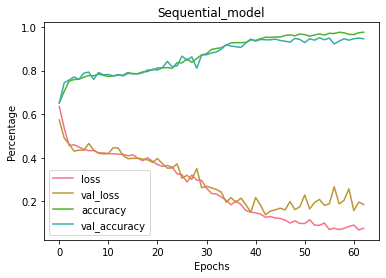

In [90]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'],label = 'val_loss')
plt.plot(history.history['accuracy'], label = 'accuracy');
plt.plot(history.history['val_accuracy'], label = 'val_accuracy');
plt.title("Sequential_model");
plt.ylabel("Percentage");
plt.xlabel("Epochs");
plt.legend()

plt.savefig('sequential_model')

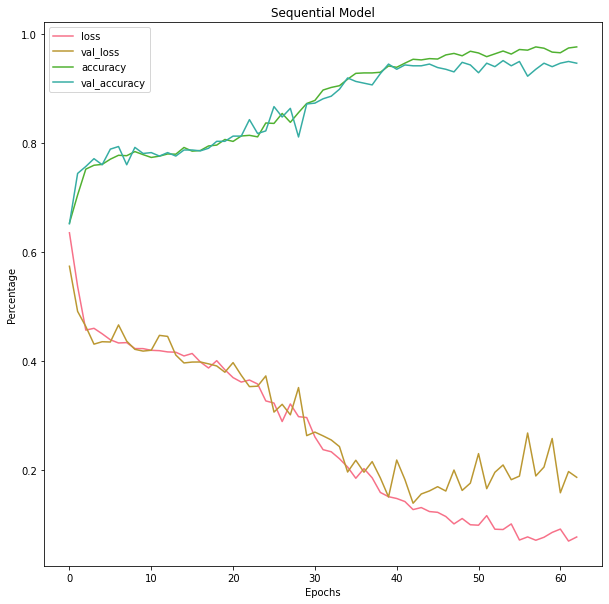

In [92]:
plt.figure(figsize=(10,10))
sns.set_palette("husl")
sns.lineplot(x = range(63), y = history.history['loss'], palette = palette, label = 'loss')
sns.lineplot(x = range(63), y = history.history['val_loss'], palette = palette, label = 'val_loss')
sns.lineplot(x = range(63), y = history.history['accuracy'], palette = palette, label = 'accuracy')
sns.lineplot(x = range(63), y = history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel("Epochs")
plt.ylabel("Percentage")
plt.title('Sequential Model')
plt.legend()
plt.show()

In [46]:
AlexNet = Sequential([
    layers.Conv2D(128, 6, activation="relu", padding="same", input_shape=[256,256,3]),#input shape: [rows, columns, channels]
    layers.MaxPooling2D(4),
    layers.Conv2D(128, 2, activation="relu", padding="same"),
    layers.MaxPooling2D(4),
    layers.Conv2D(128, 2, activation="relu", padding="same"),
    layers.Conv2D(256, 2, activation="relu", padding="same"),
    layers.Conv2D(256, 2, activation="relu", padding="same"),
    layers.MaxPooling2D(2),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(2, activation="softmax")
])
AlexNet.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [49]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
mc = ModelCheckpoint('best_model.h5')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history1 = AlexNet.fit(train_gen,
                    epochs=500,
                    validation_data = valid_gen,
                    callbacks = [es])#,mc])
score = model.evaluate(valid_gen, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])  # this is the one we care about

Epoch 1/500
79/79 [==============================] - 190s 2s/step - loss: 0.6324 - accuracy: 0.6445 - val_loss: 0.5753 - val_accuracy: 0.6401
Epoch 2/500
79/79 [==============================] - 190s 2s/step - loss: 0.5314 - accuracy: 0.6962 - val_loss: 0.4717 - val_accuracy: 0.7420
Epoch 3/500
79/79 [==============================] - 218s 3s/step - loss: 0.4702 - accuracy: 0.7412 - val_loss: 0.4763 - val_accuracy: 0.7580
Epoch 4/500
79/79 [==============================] - 202s 3s/step - loss: 0.4561 - accuracy: 0.7547 - val_loss: 0.4684 - val_accuracy: 0.7484
Epoch 5/500
79/79 [==============================] - 211s 3s/step - loss: 0.4420 - accuracy: 0.7714 - val_loss: 0.4471 - val_accuracy: 0.7643
Epoch 6/500
79/79 [==============================] - 210s 3s/step - loss: 0.4302 - accuracy: 0.7769 - val_loss: 0.4613 - val_accuracy: 0.7436
Epoch 7/500
79/79 [==============================] - 211s 3s/step - loss: 0.4411 - accuracy: 0.7674 - val_loss: 0.4324 - val_accuracy: 0.7755
Epoch 

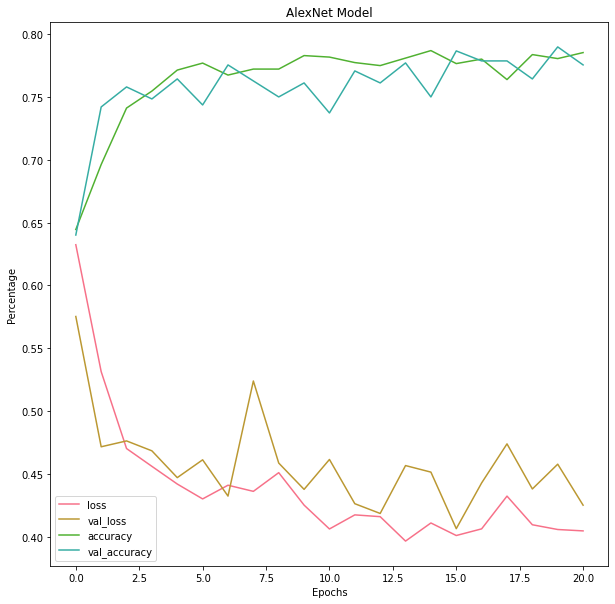

In [52]:
plt.figure(figsize=(10,10))
sns.set_palette("husl")
sns.lineplot(x = range(21), y = history1.history['loss'],  label = 'loss')
sns.lineplot(x = range(21), y = history1.history['val_loss'],label = 'val_loss')
sns.lineplot(x = range(21), y = history1.history['accuracy'], label = 'accuracy')
sns.lineplot(x = range(21), y = history1.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel("Epochs")
plt.ylabel("Percentage")
plt.title('AlexNet Model')
plt.legend()
plt.show()

In [12]:
model = Sequential([
    layers.Conv2D(128, 6, activation="relu", padding="same",input_shape=[256,256,3]),#input shape: [rows, columns, channels]
    layers.MaxPooling2D(4),
    layers.Conv2D(128, 2, activation="relu", padding="same"),
    layers.Conv2D(128, 2, activation="relu", padding="same"),
    layers.MaxPooling2D(4),
    layers.Conv2D(256, 2, activation="relu", padding="same"),
    layers.Conv2D(256, 2, activation="relu", padding="same"),
    layers.MaxPooling2D(2),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(2, activation="softmax")
])
model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

NameError: name 'Sequential' is not defined

In [33]:
from d2l import tensorflow as d2l

class Inception(tf.keras.Model):
    # `c1`--`c4` are the number of output channels for each path
    def __init__(self, c1, c2, c3, c4):
        super().__init__()
        # Path 1 is a single 1 x 1 convolutional layer
        self.p1_1 = tf.keras.layers.Conv2D(c1, 1, activation='relu', padding="same")
        # Path 2 is a 1 x 1 convolutional layer followed by a 3 x 3
        # convolutional layer
        self.p2_1 = tf.keras.layers.Conv2D(c2[0], 1, activation='relu', padding="same")
        self.p2_2 = tf.keras.layers.Conv2D(c2[1], 3, padding='same',
                                           activation='relu')
        # Path 3 is a 1 x 1 convolutional layer followed by a 5 x 5
        # convolutional layer
        self.p3_1 = tf.keras.layers.Conv2D(c3[0], 1, activation='relu', padding="same")
        self.p3_2 = tf.keras.layers.Conv2D(c3[1], 5, padding='same',
                                           activation='relu')
        # Path 4 is a 3 x 3 maximum pooling layer followed by a 1 x 1
        # convolutional layer
        self.p4_1 = tf.keras.layers.MaxPool2D(3, 1, padding='same')
        self.p4_2 = tf.keras.layers.Conv2D(c4, 1, activation='relu', padding="same")

    def call(self, x):
        p1 = self.p1_1(x)
        p2 = self.p2_2(self.p2_1(x))
        p3 = self.p3_2(self.p3_1(x))
        p4 = self.p4_2(self.p4_1(x))
        # Concatenate the outputs on the channel dimension
        return layers.Concatenate()([p1, p2, p3, p4])

In [34]:
def b1():
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, 7, strides=2, padding='same',input_shape=[256,256,3],
                               activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])
def b2():
    return Sequential([
        layers.Conv2D(64, 1, activation='relu', padding="same"),
        layers.Conv2D(192, 3, padding='same', activation='relu'),
        layers.MaxPool2D(pool_size=3, strides=2, padding='same')])
def b3():
    return Sequential([
        Inception(64, (96, 128), (16, 32), 32),
        Inception(128, (128, 192), (32, 96), 64),
        layers.MaxPool2D(pool_size=3, strides=2, padding='same')])
def b4():
    return Sequential([
        Inception(192, (96, 208), (16, 48), 64),
        Inception(160, (112, 224), (24, 64), 64),
        Inception(128, (128, 256), (24, 64), 64),
        Inception(112, (144, 288), (32, 64), 64),
        Inception(256, (160, 320), (32, 128), 128),
        layers.MaxPool2D(pool_size=3, strides=2, padding='same')])
def b5():
    return Sequential([
        Inception(256, (160, 320), (32, 128), 128),
        Inception(384, (192, 384), (48, 128), 128),
        layers.GlobalAvgPool2D(),
        layers.Flatten()])

def net():
    return Sequential([
        b1(), b2(), b3(),
        b4(), b5(), layers.Dense(10), layers.Dense(2), layers.Activation('softmax')])

In [35]:
GoogleNet = net()
opt = optimizers.Adam(learning_rate=0.001)
GoogleNet.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

In [37]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
mc = ModelCheckpoint('Googs')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history2 = GoogleNet.fit(train_gen,
                    epochs=500,
                    validation_data = valid_gen,
                    callbacks = [es])#,mc])
score = GoogleNet.evaluate(valid_gen, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1]) 

Epoch 1/500
79/79 [==============================] - 252s 3s/step - loss: 0.7166 - accuracy: 0.6390 - val_loss: 0.6579 - val_accuracy: 0.6401
Epoch 2/500
79/79 [==============================] - 246s 3s/step - loss: 0.6495 - accuracy: 0.6498 - val_loss: 0.6552 - val_accuracy: 0.6401
Epoch 3/500
79/79 [==============================] - 244s 3s/step - loss: 0.6369 - accuracy: 0.6577 - val_loss: 0.6248 - val_accuracy: 0.6401
Epoch 4/500
79/79 [==============================] - 246s 3s/step - loss: 0.5974 - accuracy: 0.6595 - val_loss: 0.6158 - val_accuracy: 0.6401
Epoch 5/500
79/79 [==============================] - 244s 3s/step - loss: 0.5969 - accuracy: 0.6545 - val_loss: 0.6115 - val_accuracy: 0.6401
Epoch 6/500
79/79 [==============================] - 243s 3s/step - loss: 0.5872 - accuracy: 0.6510 - val_loss: 0.5934 - val_accuracy: 0.6401
Epoch 7/500
79/79 [==============================] - 243s 3s/step - loss: 0.5812 - accuracy: 0.6650 - val_loss: 0.6054 - val_accuracy: 0.6401
Epoch 

In [53]:
clear_session()

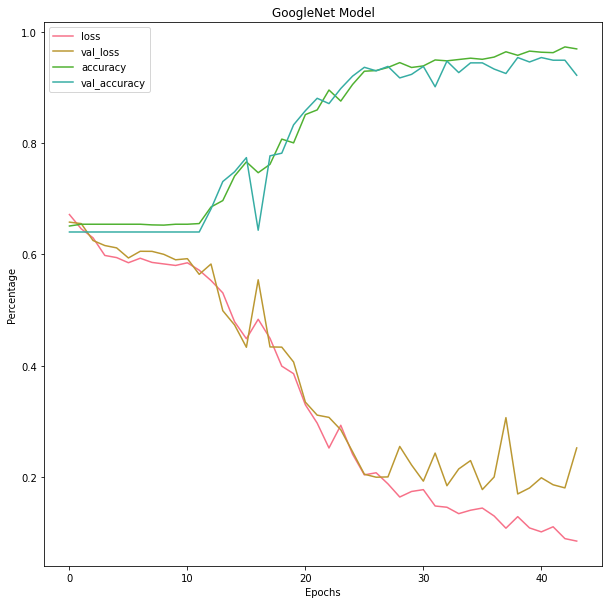

In [41]:
plt.figure(figsize=(10,10))
sns.set_palette("husl")
sns.lineplot(x = range(44), y = history2.history['loss'], label = 'loss')
sns.lineplot(x = range(44), y = history2.history['val_loss'], label = 'val_loss')
sns.lineplot(x = range(44), y = history2.history['accuracy'], label = 'accuracy')
sns.lineplot(x = range(44), y = history2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel("Epochs")
plt.ylabel("Percentage")
plt.title('GoogleNet Model')
plt.legend()
plt.show()

In [57]:
LeNet = Sequential([
    layers.Conv2D(128, 6, activation="relu", padding="same",input_shape=[256,256,3]),#input shape: [rows, columns, channels]
    layers.AveragePooling2D(4),
    layers.Conv2D(128, 6, activation="relu", padding="same"),
    layers.AveragePooling2D(4),
    layers.Conv2D(128, 6, activation="relu", padding="same"),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(2, activation="softmax")])
LeNet.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [59]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history3 = LeNet.fit(train_gen,
                    epochs=500,
                    validation_data = valid_gen,
                    callbacks = [es])#,mc])
score = LeNet.evaluate(valid_gen, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1]) 

Epoch 1/500
79/79 [==============================] - 425s 5s/step - loss: 0.6725 - accuracy: 0.6190 - val_loss: 0.5827 - val_accuracy: 0.6401
Epoch 2/500
79/79 [==============================] - 381s 5s/step - loss: 0.5468 - accuracy: 0.6828 - val_loss: 0.5289 - val_accuracy: 0.7150
Epoch 3/500
79/79 [==============================] - 377s 5s/step - loss: 0.5015 - accuracy: 0.7432 - val_loss: 0.4844 - val_accuracy: 0.7468
Epoch 4/500
79/79 [==============================] - 332s 4s/step - loss: 0.4610 - accuracy: 0.7595 - val_loss: 0.3979 - val_accuracy: 0.8010
Epoch 5/500
79/79 [==============================] - 337s 4s/step - loss: 0.4293 - accuracy: 0.7834 - val_loss: 0.3614 - val_accuracy: 0.8280
Epoch 6/500
79/79 [==============================] - 356s 5s/step - loss: 0.3499 - accuracy: 0.8339 - val_loss: 0.3283 - val_accuracy: 0.8519
Epoch 7/500
79/79 [==============================] - 381s 5s/step - loss: 0.3250 - accuracy: 0.8592 - val_loss: 0.3455 - val_accuracy: 0.8567
Epoch 

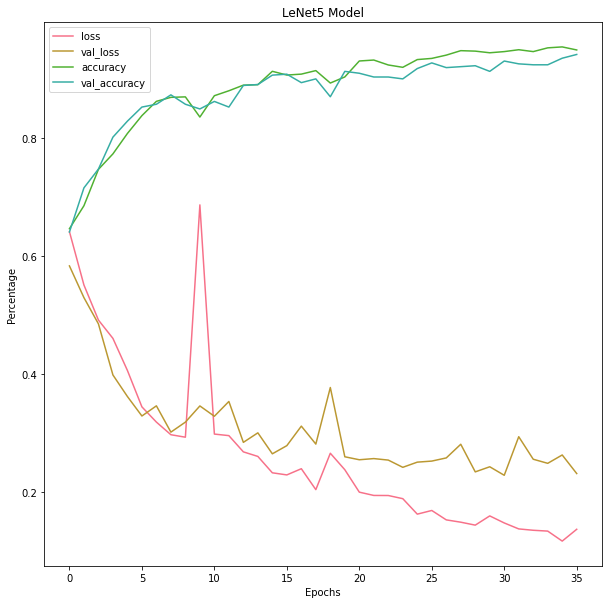

In [61]:
plt.figure(figsize=(10,10))
sns.set_palette("husl")
sns.lineplot(x = range(36), y = history3.history['loss'], label = 'loss')
sns.lineplot(x = range(36), y = history3.history['val_loss'], label = 'val_loss')
sns.lineplot(x = range(36), y = history3.history['accuracy'], label = 'accuracy')
sns.lineplot(x = range(36), y = history3.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel("Epochs")
plt.ylabel("Percentage")
plt.title('LeNet5 Model')
plt.legend()
plt.show()

In [114]:
model = Sequential([
    layers.Conv2D(128, 6, activation="relu", padding="same",input_shape=[256,256,3]),#input shape: [rows, columns, channels]
    layers.MaxPooling2D(4),
    layers.Conv2D(128, 2, activation="relu", padding="same"),
    layers.Conv2D(128, 2, activation="relu", padding="same"),
    layers.MaxPooling2D(4),
    layers.Conv2D(256, 2, activation="relu", padding="same"),
    layers.Conv2D(256, 2, activation="relu", padding="same"),
    layers.MaxPooling2D(2),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(2, activation="softmax")])

Please input a random number between 1 and 100: 7


ValueError: in user code:

    /Users/distantbeliefs/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1478 predict_function  *
        return step_function(self, iterator)
    /Users/distantbeliefs/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/distantbeliefs/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/distantbeliefs/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/distantbeliefs/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/distantbeliefs/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1461 run_step  **
        outputs = model.predict_step(data)
    /Users/distantbeliefs/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1434 predict_step
        return self(x, training=False)
    /Users/distantbeliefs/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /Users/distantbeliefs/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:239 assert_input_compatibility
        str(tuple(shape)))

    ValueError: Input 0 of layer sequential_1 is incompatible with the layer: : expected min_ndim=4, found ndim=3. Full shape received: (32, 256, 3)


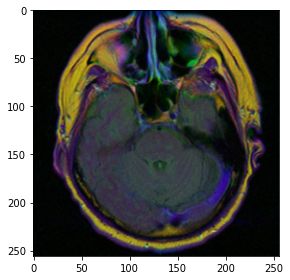

In [115]:
Xnew = int(input('Please input a random number between 1 and 100: '))

fig, axs = plt.subplots()
img = io.imread(brain_df.image_path[Xnew])
axs.imshow(img)
fig.tight_layout()

test_idg = ImageDataGenerator(rescale=1/255, shear_range = 0.2, zoom_range = 0.2,)
y_proba = model.predict(img)
#y_classes = keras.np_utils.probas_to_classes(y_proba)

ValueError: Could not find a format to read the specified file in mode 'i'

Please input a random number between 1 and 100: 5


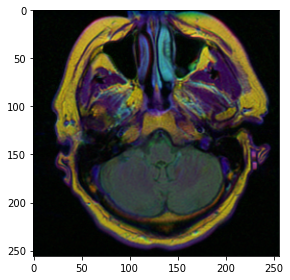

In [109]:
Xnew = int(input('Please input a random number between 1 and 100: '))
fig, axs = plt.subplots()
img = io.imread(brain_df.image_path[Xnew])
axs.imshow(img)
fig.tight_layout()